In [1]:
%matplotlib inline
import sys
import math
import psycopg2
import psycopg2.extras
import numpy as np
import pandas
from matplotlib import pyplot
from astropy import units
from astropy.coordinates import SkyCoord

In [2]:
dbhost = "decatdb.lbl.gov"
dbname = "desi"
dbuser = "desi"
dbpasswd = "5kFibers!"

In [52]:
dbconn = psycopg2.connect( f"dbname='{dbname}' host='{dbhost}' user='{dbuser}' password='{dbpasswd}'",
                         cursor_factory=psycopg2.extras.RealDictCursor )

There are a few tables that are relevant here.  The table `mosthosts.mosthosts` table has all the information from Maayane's CSV file.  Columns include:
- `ra` (degrees)
- `dec` (degrees)
- `snname` (some sort of primary name for the supernova)
- `hemisphere` (north or south)
- `sn_ra` (RA of the supernova this is a possible host for)
- `sn_dec` (dec of the supernova this is a possible host for)
- `sn_z` (redshift (determined how?) of supernova)
- `program` (some indicator of where this supernova came from; multiple things are /-separated)
- `tns_name` (not sure what tns is)
- `iau_name` (IAU name if the SN has one)
- `ptfiptf_name` (probably something from PTF)

In [53]:
# Aside: statistics
# Count number of supernovae and number of distinct supernovae in the table
q = "SELECT COUNT(snname) AS num FROM mosthosts.mosthosts"
cursor = dbconn.cursor()
cursor.execute( q )
row = cursor.fetchone()
print( f'There are {row["num"]} entries in the mosthosts table.' )

q = "SELECT COUNT(DISTINCT snname) AS num FROM mosthosts.mosthosts"
cursor.execute( q )
row = cursor.fetchone()
print( f'There are {row["num"]} distinct supernovae in the mosthosts table.' )

There are 20174 entries in the mosthosts table.
There are 14958 distinct supernovae in the mosthosts table.


Histogram of sn_z in mosthosts


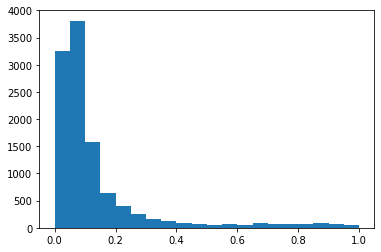

In [54]:
# Make a histogram of redshifts
q = "SELECT sn_z FROM mosthosts.mosthosts"
cursor.execute( q )
rows = cursor.fetchall()
zvals = np.array( [ row["sn_z"] for row in rows ] )
# fig,ax = pyplot.subplots()
pyplot.hist( zvals, range=(0,1), bins=20 )
print( "Histogram of sn_z in mosthosts" )

In [59]:
# Read the mostshosts table into variable mostshosts
cursor = dbconn.cursor()
q = "SELECT ra,dec,snname,sn_ra,sn_dec,sn_z,program,tns_name,iau_name,ptfiptf_name FROM mosthosts.mosthosts"
cursor.execute( q )
mosthosts = pandas.DataFrame( cursor.fetchall() )

# Because the same supernova shows up more than once sometimes (multiple possible hosts), let's
#   add a column that indexes the hosts for that one supernova, and then rearrange the table

mosthosts.insert( loc=0, column='snhostnum', value=mosthosts.groupby( 'snname' ).cumcount() )
mosthosts = mosthosts.set_index( ['snname', 'snhostnum' ] )
mosthosts = mosthosts.sort_index()

In [61]:
# It's possible that some of the mosthosts targets were observed with DESI targetids
#  other than what shows up in the secondary table.  So, just search the daily table directly for ra/dec
cursor = dbconn.cursor()
nhist = np.zeros( 11, dtype=int )
nhistnowarn = np.zeros( 11, dtype=int )

fields = [ 'targetid', 'z', 'zerr', 'zwarn', 'spectype', 'subtype', 'deltachi2' ]
newfields = {}
for field in fields:
    newfields[ f'zpix_{field}' ] = []
    newfields[ f'zpix_nowarn_{field}' ] = []

for i in range(len(mosthosts)):
    row = mosthosts.iloc[i]
    if (i%1000 == 0):
        sys.stderr.write( f'Did {i} of {len(mosthosts)}; {i-nhist[0]:d} have at least 1 match\n' )
    q = ( "SELECT f.targetid,z.z,z.zerr,z.zwarn,z.spectype,z.subtype,z.deltachi2 FROM public.zbest_daily z "
          "INNER JOIN public.fibermap_daily f ON (f.targetid,f.tileid,f.night)=(z.targetid,z.tile,z.yyyymmdd) "
          "WHERE q3c_radial_query(f.fiber_ra,f.fiber_dec,%s,%s,1./3600)" )
    cursor.execute( q, ( row['ra'], row['dec'] ) )
    matches = cursor.fetchall()
    n = len(matches)
    for field in fields:
        newfields[f'zpix_{field}'].append( [ match[field] for match in matches ] )
        newfields[f'zpix_nowarn_{field}'].append( [ match[field] for match in matches if match['zwarn']==0 ] )
    nnowarn = len(newfields['zpix_nowarn_targetid'][-1])
    if n >= 10:
        nhist[10] += 1
    else:
        nhist[n] += 1
    if nnowarn >= 10:
        nhistnowarn[10] += 1
    else:
        nhistnowarn[nnowarn] += 1
        
for field in fields:
    mosthosts[ f'zpix_{field}' ] = newfields[ f'zpix_{field}' ]
    mosthosts[ f'zpix_nowarn_{field}' ] = newfields[ f'zpix_nowarn_{field}' ]
        
sys.stderr.flush()
for i,val in enumerate(nhist):
    if i == 10:
        print( f'{val:5d} have {i:2d}+ matches' )
    else:
        print( f'{val:5d} have {i:2d} matches' )
for i,val in enumerate(nhistnowarn):
    if i == 10:
        print( f'{val:5d} have {i:2d}+ matches with zwarn=0' )
    else:
        print( f'{val:5d} have {i:2d} matches with zwarn=0' )
totobs = 0
totnowarn = 0
for num,nowarnnum in zip(nhist[1:],nhistnowarn[1:]):
    totobs += num
    totnowarn += nowarnnum
print( f'{totobs} mosthosts entries match to one or more DESI observation ra/dec; {totnowarn} with at least one zwarn=0' )

Did 0 of 20174; 0 have at least 1 match
Did 1000 of 20174; 95 have at least 1 match
Did 2000 of 20174; 210 have at least 1 match
Did 3000 of 20174; 306 have at least 1 match
Did 4000 of 20174; 510 have at least 1 match
Did 5000 of 20174; 641 have at least 1 match
Did 6000 of 20174; 781 have at least 1 match
Did 7000 of 20174; 840 have at least 1 match
Did 8000 of 20174; 898 have at least 1 match
Did 9000 of 20174; 962 have at least 1 match
Did 10000 of 20174; 1045 have at least 1 match
Did 11000 of 20174; 1111 have at least 1 match
Did 12000 of 20174; 1160 have at least 1 match
Did 13000 of 20174; 1200 have at least 1 match
Did 14000 of 20174; 1250 have at least 1 match
Did 15000 of 20174; 1317 have at least 1 match
Did 16000 of 20174; 1391 have at least 1 match
Did 17000 of 20174; 1474 have at least 1 match
Did 18000 of 20174; 1527 have at least 1 match
Did 19000 of 20174; 1607 have at least 1 match
Did 20000 of 20174; 1719 have at least 1 match


18414 have  0 matches
 1334 have  1 matches
  257 have  2 matches
   92 have  3 matches
   26 have  4 matches
   22 have  5 matches
   16 have  6 matches
    9 have  7 matches
    0 have  8 matches
    2 have  9 matches
    2 have 10+ matches
18470 have  0 matches with zwarn=0
 1306 have  1 matches with zwarn=0
  243 have  2 matches with zwarn=0
   82 have  3 matches with zwarn=0
   24 have  4 matches with zwarn=0
   23 have  5 matches with zwarn=0
   13 have  6 matches with zwarn=0
    9 have  7 matches with zwarn=0
    0 have  8 matches with zwarn=0
    2 have  9 matches with zwarn=0
    2 have 10+ matches with zwarn=0
1760 mosthosts entries match to one or more DESI observation ra/dec; 1704 with at least one zwarn=0


In [13]:
cursor.close()
dbconn.close()

# Look here
## The mosthosts variable is a useful Pandas DataFrame

Each row is indexed by `snname` and `snhostnum`.  The second just counts the hosts that have the same snname.  For SNe with a single host, this will just be 0.

The dataframe has the following columns

* ra,dec,snname,sn_ra,sn_dec,sn_z,program,tns_name,iau_name,ptfiptf_name from the original mosthosts table
* zpix_targetid, zpix_z, zpix_zerr, zpix_zwarn, zpix_spectype, zpix_subtype, zpix_deltachi2 : each is a list of things matched to the daily tables
* zpix_nowarn_* : all the above fields, but only with zpix_zwarn = 0

In [129]:
# Let's extract a subset of these supernovae that have at least one
# redshift measurement
# There are so many combinations.  So, for now, I'm going to restrict
# myself only to zwarn=0 observations.  Also, for now, I'm going to
# ignore the secondary table, and look directly at the everest ra/dec
# match.  (Sometime I should verify that all secondary targetids also
# show up in the everest match.)

hostswithz = mosthosts[ mosthosts['zpix_nowarn_targetid'].map(len) > 0 ]
nsne = len( hostswithz.groupby( 'snname' ) )
print( f'Of the {nsne} SNe/QSOs that have at least one DESI observation:' )

hostcountspersne = hostswithz.groupby( 'snname' ).agg('count')['ra'].to_frame('nhosts')
# I haven't fully wrapped my head around Pandas, but I think we have to
#  have a column we're not grouping on to count
hostcountspersne['it'] = 0
hostcounts = hostcountspersne.groupby( 'nhosts' ).agg('count')['it'].to_frame('nsne')

for i, row in hostcounts.iterrows():
    print( f'{row["nsne"]:5d} SNe/QSOs have {i} hosts observed by DESI.' )
print( f'Only counts zwarn=0 observations.' )

Of the 1645 SNe/QSOs that have at least one DESI observation:
 1593 SNe/QSOs have 1 hosts observed by DESI.
   46 SNe/QSOs have 2 hosts observed by DESI.
    5 SNe/QSOs have 3 hosts observed by DESI.
    1 SNe/QSOs have 4 hosts observed by DESI.
Only counts zwarn=0 observations.


In [139]:
# Write out a CSV file with the redshift information for the hosts we have

def combinez( row ):
    if len(row['zpix_nowarn_z']) == 0:
        return { 'z': -9999, 'dz': 0, 'zdisp': 0 }
    hostzs = np.array( row['zpix_nowarn_z'] )
    hostzerrs = np.array( row['zpix_nowarn_zerr'] )
    z = ( hostzs / hostzerrs**2 ).sum() / ( 1. / hostzerrs**2 ).sum()
    dz = 1. / math.sqrt( (1. / hostzerrs**2).sum() )
    return { 'z': z, 'dz': dz, 'zdisp': hostzs.max()-hostzs.min() }

hostzvals = hostswithz.apply( combinez, axis=1, result_type='expand' )
hostzvals = hostzvals.merge( hostswithz,
                             how='left', left_index=True, right_index=True )
hostzvals.to_csv( 'mosthosts_sne_z.csv',
                  columns=[ 'z', 'dz', 'zdisp', 'tns_name', 'iau_name', 'ptfiptf_name'] )

print( 'File mosthosts_sne_z.csv written (I hope).' )


File mosthosts_sne_z.csv written (I hope).


1645 different SNe/QSOs have redshifts


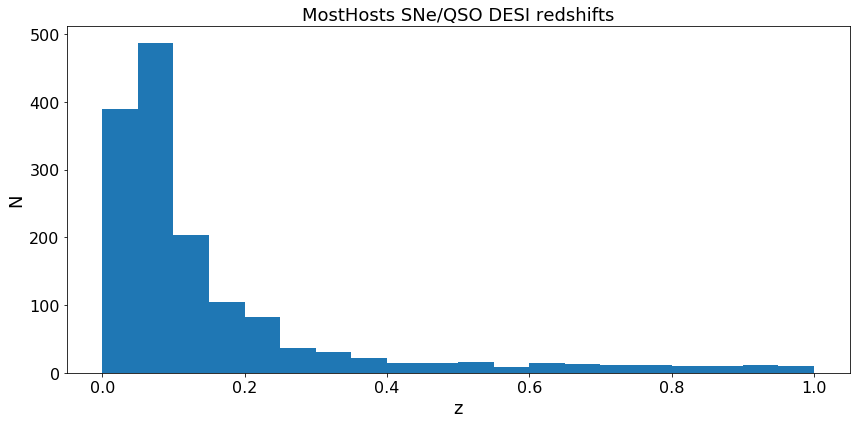

In [145]:
# Make a histogram of *independent* supernova zs.  I'm just going to take the first measurement
#  for each supernova... which may well not be the right one!

subframe = hostzvals.groupby( 'snname' ).agg('first')
print( f'{len(subframe)} different SNe/QSOs have redshifts' )

# Let's make a histogram of those zs
fig = pyplot.figure( figsize=(12,6), tight_layout=True )
ax = fig.add_subplot(1, 1, 1)
ax.hist( subframe['z'], range=(0,1), bins=20)
ax.set_xlabel('z', fontsize=18)
ax.set_ylabel('N', fontsize=18)
ax.set_title( 'MostHosts SNe/QSO DESI redshifts', fontsize=18 )
#ax.set_yscale('log')
ax.tick_params( axis='both', labelsize=16 )
# fig.tight_layout()
fig.show()
fig.savefig( 'mosthostsz.svg' )


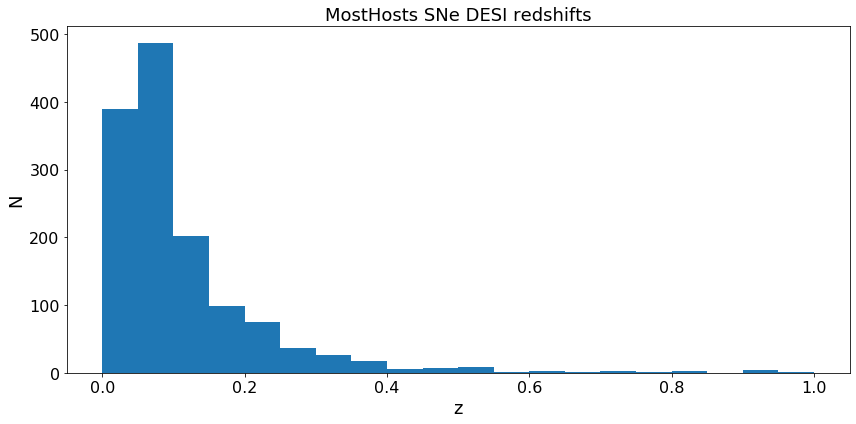

In [146]:
# Make another histogram omitting things that are in the "Mat_QSO" program

subframe = hostzvals[ hostzvals['program'].map( lambda x : 'Mat_QSO' not in x ) ].groupby( 'snname' ).agg('first')

fig = pyplot.figure( figsize=(12,6), tight_layout=True )
ax = fig.add_subplot(1, 1, 1)
ax.hist( subframe['z'], range=(0,1), bins=20)
ax.set_xlabel('z', fontsize=18)
ax.set_ylabel('N', fontsize=18)
ax.set_title( 'MostHosts SNe DESI redshifts', fontsize=18 )
#ax.set_yscale('log')
ax.tick_params( axis='both', labelsize=16 )
# fig.tight_layout()
fig.show()

fig.savefig('mosthostsz_SNe.svg')